<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous allons donner une définition novice de la sinistralité, et nous allons implémenter un GLM pour voir l'évolution temporelle de la sinistralité, ainsi que l'évolution régionale de cette dernière.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous allons nous intéressé au reste à charge comme mesure de sinistralité car cela nous donne, dans la plupart des postes de soins, sur le prix maximale que doit payer les assurances aux assurés.
Et par reste à charge nous insinuons le ticket modérateur d'une prestation de santé + les éventuels dépassement d'honoraires.</p>



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Dictionnaires nécessaires</b></h2>

In [2]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Hauts-de-France",
    44: "Grand Est",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Importation des librairies nécessaires</b></h2>

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, gamma, skewnorm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore', category=UserWarning)


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [4]:
df = pd.read_csv("../../page 3/RAC_nouveau.csv")

Aperçu des données

In [5]:
df.head()

,FLX_ANN_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,201901.0,2.0,70.0,5.0,4175537.69,2.538271e+07,2.120717e+07
1,201901.0,2.0,80.0,24.0,7357488.44,3.480094e+07,2.744345e+07
2,201901.0,1.0,0.0,52.0,9717960.12,2.445639e+07,1.473843e+07
3,201901.0,2.0,60.0,5.0,5179146.18,2.548382e+07,2.030468e+07
4,201901.0,1.0,40.0,52.0,6926479.09,2.127533e+07,1.434885e+07


Changement de types et extraction des mois et de l'année

In [6]:
df = df.astype({
    'FLX_ANN_MOI': 'str',
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32'
})
df['annee'] = df['FLX_ANN_MOI'].str[: 4].astype('int32')
df['mois'] = df['FLX_ANN_MOI'].str[4: 6].astype('int32')
df.drop(columns=['FLX_ANN_MOI'], inplace=True)
df.head()

,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT,annee,mois
0,2,70,5,4175537.69,2.538271e+07,2.120717e+07,2019,1
1,2,80,24,7357488.44,3.480094e+07,2.744345e+07,2019,1
2,1,0,52,9717960.12,2.445639e+07,1.473843e+07,2019,1
3,2,60,5,5179146.18,2.548382e+07,2.030468e+07,2019,1
4,1,40,52,6926479.09,2.127533e+07,1.434885e+07,2019,1


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [7]:

df.rename(columns = {'AGE_BEN_SNDS': 'age', 'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

df['region'] = df['region'].map(region_mapping)

df_grouped = df.drop(columns = ['PAI', 'REM', 'age', 'sexe']).groupby(by = ['annee', 'mois',  'region']).sum()

df_grouped.reset_index(inplace=True)

df_grouped


,annee,mois,region,RAC
0,2019,1,Auvergne-Rhône-Alpes,3.258587e+08
1,2019,1,Bourgogne-Franche-Comté,1.011125e+08
2,2019,1,Bretagne,1.138065e+08
3,2019,1,Centre-Val-de-Loire,9.193878e+07
4,2019,1,Grand Est,2.519127e+08
...,...,...,...,...
931,2024,12,Nouvelle-Aquitaine,2.964126e+08
932,2024,12,Occitanie,2.937130e+08
933,2024,12,Pays de la Loire,1.683764e+08
934,2024,12,Provence-Alpes-Côte d'Azur et Corse,3.012519e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ population</b></h2>

Importation des données démographiques 

In [8]:
years = np.append(np.array([2018]), df_grouped['annee'].unique())
year_population_dataframes = {}
for year in years:
    print(f"Dataframe crée pour l'année {year}")
    df_year = pd.read_csv(f"../../CSV demographie/population par région fin {year}.csv", sep=';', decimal = ' ', encoding= "latin")
    df_year = pd.melt(df_year, value_vars=['Hommes','Femmes'], value_name="population", var_name="sexe", id_vars="Région")
    df_year['annee'] = year
    df_year.rename(columns={'Région': 'region'}, inplace=True)
    df_year.drop(columns= ['sexe'], inplace=True)
    df_year['population'] = df_year['population'].str.replace(' ','')
    df_year['population'] = df_year['population'].astype(float)
    df_year = df_year.groupby(by = ['annee', 'region']).sum().reset_index()
    year_population_dataframes[year] = df_year

year_population_dataframes[2018]

Dataframe crée pour l'année 2018
Dataframe crée pour l'année 2019
Dataframe crée pour l'année 2020
Dataframe crée pour l'année 2021
Dataframe crée pour l'année 2022
Dataframe crée pour l'année 2023
Dataframe crée pour l'année 2024


,annee,region,population
0,2018,Auvergne-Rhône-Alpes,8042936.0
1,2018,Bourgogne-Franche-Comté,2805580.0
2,2018,Bretagne,3354854.0
3,2018,Centre-Val-de-Loire,2573180.0
4,2018,Grand Est,5556219.0
5,2018,Hauts-de-France,6004947.0
6,2018,Ile-de-France,12262544.0
7,2018,Normandie,3325032.0
8,2018,Nouvelle-Aquitaine,6010289.0
9,2018,Occitanie,5933185.0


Interpolation mensuelle des données démographiques par région

In [9]:
def interpolate_population(data_1, data_2):
    df_year_1 = data_1.copy()
    df_year_2 = data_2.copy()
    
    # Calculate the difference in yearly population and divide by 12 for monthly increments
    difference_yearly_pop = ((df_year_2['population'] - df_year_1['population']) / 12).to_list()
    
    # Create a list of interpolated monthly populations
    df_year_2['monthly_population'] = [
        [df_year_1['population'].iloc[i] + j * difference_yearly_pop[i] for j in range(1, 13)]
        for i in range(len(df_year_1))
    ]
    df_year_2['mois'] = list(range(1,13) for _ in range(len(df_year_1))) 
    
    # Explode the list into rows
    df_year_2 = df_year_2.explode(['monthly_population', 'mois']).reset_index(drop=True)

    df_year_2.drop(columns = ['population'], inplace = True)

    df_year_2.sort_values(by = ['annee','mois'])

    return df_year_2

# interpolate all yearly_data
def interpolate_all_data(data):
    all_data = {}
    for year in sorted(data.keys())[:-1]: 
        data_1 = year_population_dataframes[year]
        data_2 = year_population_dataframes[year + 1]
        all_data[year + 1] = interpolate_population(data_1, data_2)
    
    return pd.concat(all_data.values())

all_data = interpolate_all_data(year_population_dataframes)
all_data


,annee,region,monthly_population,mois
0,2019,Auvergne-Rhône-Alpes,8045912.333333,1
1,2019,Auvergne-Rhône-Alpes,8048888.666667,2
2,2019,Auvergne-Rhône-Alpes,8051865.0,3
3,2019,Auvergne-Rhône-Alpes,8054841.333333,4
4,2019,Auvergne-Rhône-Alpes,8057817.666667,5
...,...,...,...,...
151,2024,Régions et Départements d'outre-mer,2250323.666667,8
152,2024,Régions et Départements d'outre-mer,2251157.0,9
153,2024,Régions et Départements d'outre-mer,2251990.333333,10
154,2024,Régions et Départements d'outre-mer,2252823.666667,11


Fusion des données de l'Open Damir avec les données démographiques

In [10]:
# on va merge les dataframes

copied_df = df_grouped.copy()

# Merge the dataframes on 'annee', 'age', and 'sexe'
final_df = copied_df.merge(all_data, how = 'right', on= ['annee', 'mois', 'region'], suffixes=('', '_new'))

final_df['monthly_population'] = final_df['monthly_population'].astype(float)

final_df['RAC'] = final_df['RAC'].astype(float)

final_df['mois'] = final_df['mois'].astype(int)

final_df['RAC_par_personne'] = final_df['RAC'] / final_df['monthly_population'] 

final_df.shape


(936, 6)

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation du reste à charge par région</b></h2>

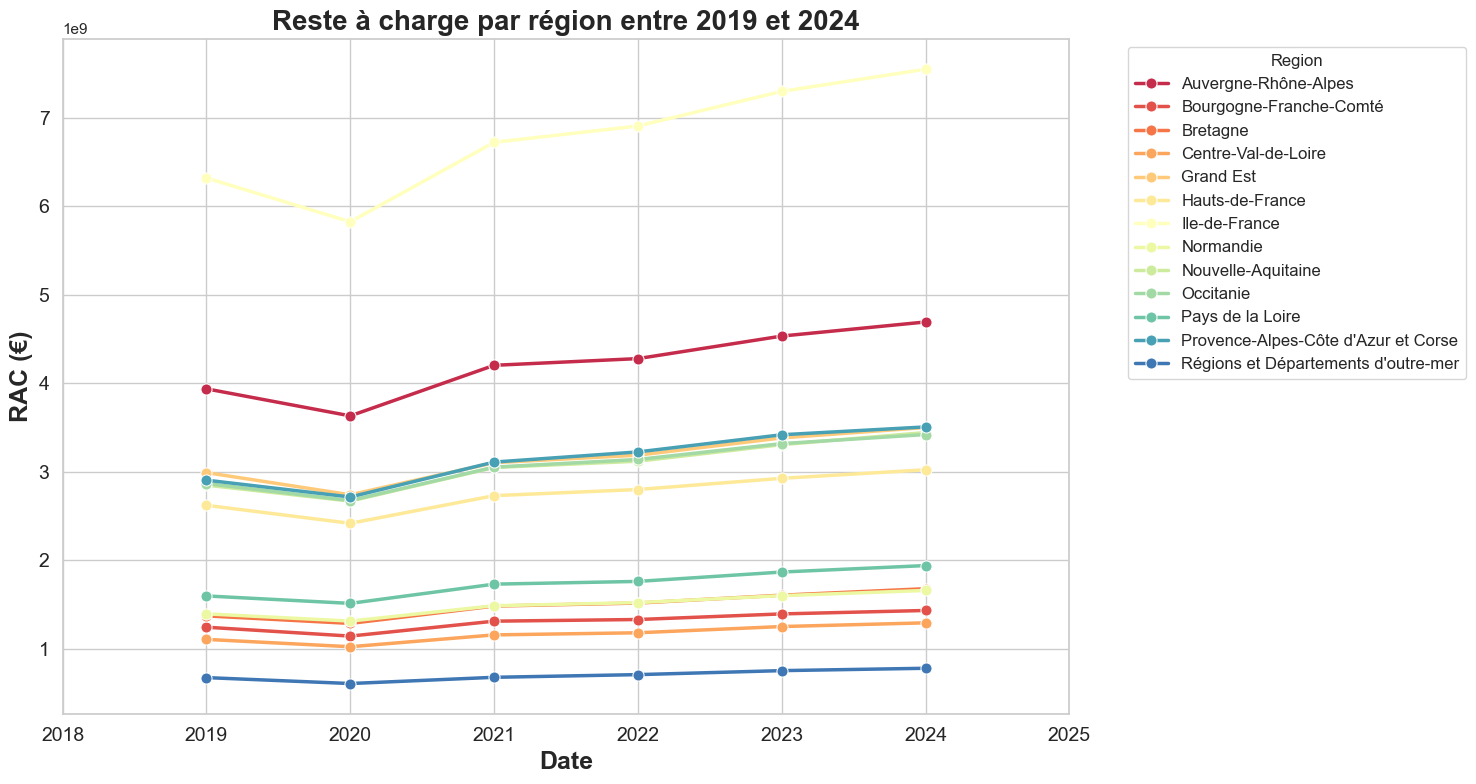

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

sns.lineplot(x="annee", y="RAC", data=final_df, hue="region", marker='o', markersize=8, linewidth=2.5, errorbar=None, estimator=np.sum, palette="Spectral")

# Title with bigger font
plt.title("Reste à charge par région entre 2019 et 2024", fontsize=20, fontweight='bold')

# Axis labels with bigger font
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust x-axis limits
plt.xlim(2018, 2025)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Region", fontsize=12)

plt.tight_layout()
plt.show()



**Remarque:** les plus grands RAC (totaux) sont enregistrés dans la région d'île de France, succédée par la région Auvergne-Rhône-Alpes

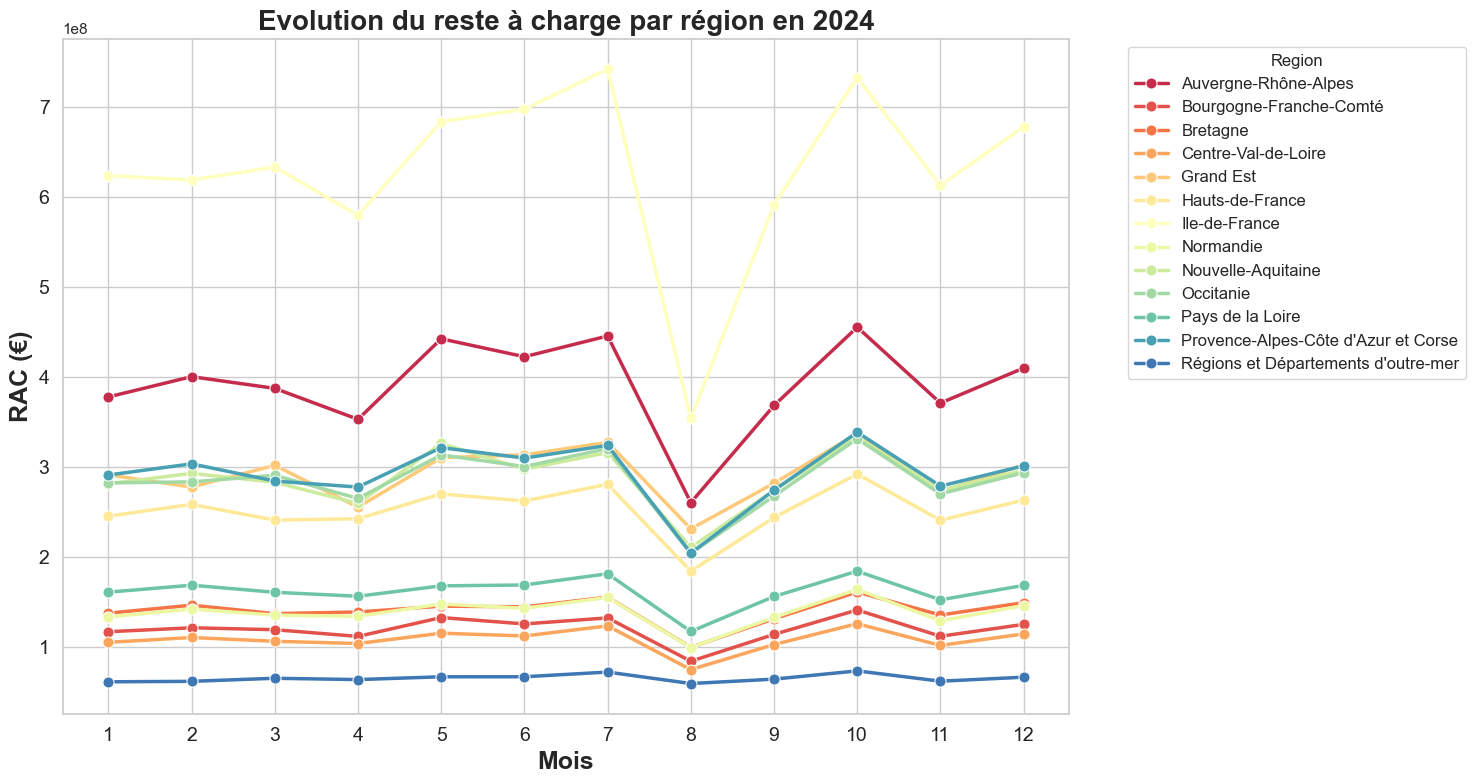

In [12]:
final_df_2024 = final_df[final_df['annee'] == 2024]

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

sns.lineplot(x="mois", y="RAC", data=final_df_2024, hue="region", marker='o', markersize=8, linewidth=2.5, errorbar=None, estimator=np.sum, palette="Spectral")

# Title with bigger font
plt.title("Evolution du reste à charge par région en 2024", fontsize=20, fontweight='bold')

# Axis labels with bigger font
plt.xlabel("Mois", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks([i for i in range(1,13)], fontsize=14)
plt.yticks(fontsize=14)


# Adjust x-axis limits

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Region", fontsize=12)

plt.tight_layout()
plt.show()



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données</b></h2>

In [13]:
def get_all_data_beginning_from_year(current_year, ending_year= 2024): 
    return final_df[(ending_year >= final_df['annee']) & (final_df['annee'] >= current_year)].sort_values(by=['annee', 'mois', 'region'])
get_all_data_beginning_from_year(2019).head()

,annee,mois,region,RAC,monthly_population,RAC_par_personne
0,2019,1,Auvergne-Rhône-Alpes,3.258587e+08,8.045912e+06,40.499912
12,2019,1,Bourgogne-Franche-Comté,1.011125e+08,2.805256e+06,36.043928
24,2019,1,Bretagne,1.138065e+08,3.356436e+06,33.906964
36,2019,1,Centre-Val-de-Loire,9.193878e+07,2.573320e+06,35.727688
48,2019,1,Grand Est,2.519127e+08,5.556755e+06,45.334501


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Conception du GLM</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Choix de la loi de probabilité que suit la dérive de sinistralité</b></h2>

In [14]:
def get_hist_from_data_beginning_from_year(year): 
    df = get_all_data_beginning_from_year(year)
    sns.histplot(data=df, x="RAC_par_personne",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")
    plt.title(f'Histogramme du reste à charge par personne par mois à partir des données de l\'année {year}')
    return 

Q-Q plot pour le choix de la loi exponentielle adéquate au données

In [15]:
def get_q_q_plots(year):

    data = get_all_data_beginning_from_year(year)['RAC_par_personne']

    # Q-Q plot vs normal
    mu, sigma = stats.norm.fit(data)
    print(f"Estimated mean (μ): {mu}")
    print(f"Estimated std dev (σ): {sigma}")

    # Q-Q plot vs normal*
    stats.probplot(data, dist="norm", sparams=(mu, sigma), plot=plt)
    plt.title("Q-Q Plot vs Fitted Normal (μ, σ)")
    plt.grid()
    plt.show()


    # Q-Q plot vs gamma*
    params = stats.gamma.fit(data)
    fig = qqplot(data, dist=stats.gamma, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Gamma Distribution")
    plt.grid()
    plt.show()

    return 


In [16]:
def apply_kolmogorov_smirnov(data): 
    # Add a constant to make the data positive for positive distributions

    # Perform Kolmogorov-Smirnov test for normal distribution
    normal_test = kstest(data, 'norm', args=(data.mean(), data.std()))
    
    # Perform Kolmogorov-Smirnov test for gamma distribution
    gamma_params = gamma.fit(data)
    gamma_test = kstest(data, 'gamma', args=gamma_params)
    
    # Perform Kolmogorov-Smirnov test for inverse Gaussian distribution
    invgauss_params = stats.invgauss.fit(data, floc=0)
    invgauss_test = kstest(data, 'invgauss', args=invgauss_params)
    
    # Perform Kolmogorov-Smirnov test for Tweedie distribution
    tweedie_params = sm.families.Tweedie(var_power=1.5).starting_mu(data)
    tweedie_test = kstest(data, 'gamma', args=(tweedie_params,))

    # Determine which distribution fits the data best with 95% confidence
    results = {
        'normal': normal_test,
        'gamma': gamma_test,
        'inverse_gaussian': invgauss_test,
        'tweedie': tweedie_test
    }
    
    # Filter distributions with p-value > 0.05 (95% confidence level)
    best_fit = {dist: "Kolmogorov Smirnov p-value is: " + str(round(float(test.pvalue) * 100, 2)) + "%" for dist, test in results.items() if test.pvalue > 0.01}
    
    

    return best_fit if best_fit else "No distribution fits the data with 95% confidence."

In [17]:
data = get_all_data_beginning_from_year(2021)['RAC_par_personne']
apply_kolmogorov_smirnov(data)

{'normal': 'Kolmogorov Smirnov p-value is: 4.2%',
 'gamma': 'Kolmogorov Smirnov p-value is: 1.26%'}

**Remarque** : La loi normale est la meilleure distribution pour laquelle l’hypothèse nulle du test de Kolmogorov-Smirnov n’est pas rejetée au seuil de 1 %, et ce uniquement pour les données à partir de 2021. Les données des années 2019 et 2020 sont jugées non représentatives, vraisemblablement en raison de la crise sanitaire. Cela se manifeste notamment par la présence de faibles montants de RAC mensuels, comme le confirment les histogrammes.

In [18]:
def GLM_model(year, ending_year= 2024):

    df_GLM = get_all_data_beginning_from_year(year, ending_year)
    X = pd.get_dummies(df_GLM, columns = ['region'], drop_first = True,  dtype=int)
    X = sm.add_constant(X)
    y = X['RAC_par_personne']
    glm_model = sm.GLM(y, sm.add_constant(X.drop(columns=['RAC_par_personne', 'RAC', 'monthly_population'])), family=sm.families.Gaussian())
    glm_results = glm_model.fit()

    return glm_model, glm_results


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Dans la section suivante, on va chercher l'année à partie de laquelle on obtient un bon modèle GLM</b></h2>



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>À partir de l'année 2019</b></h2>

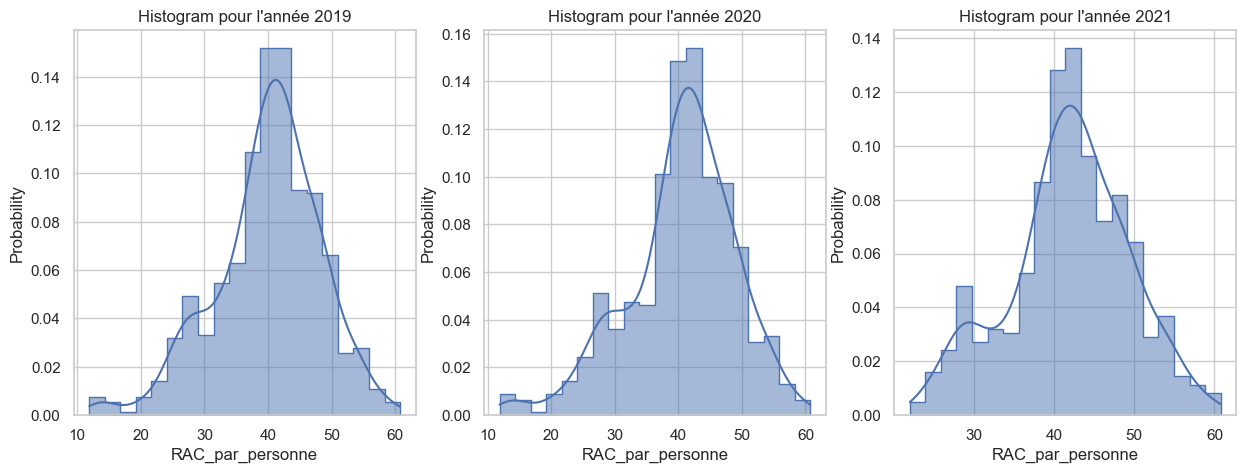

In [19]:
year = 2021
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title(f"Histogram pour l'année {year-2}")
sns.histplot(data=get_all_data_beginning_from_year(year-2), x="RAC_par_personne", stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step", ax=axes[0])

axes[1].set_title(f"Histogram pour l'année {year-1}")
sns.histplot(data=get_all_data_beginning_from_year(year-1), x="RAC_par_personne", stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step", ax=axes[1])

axes[2].set_title(f"Histogram pour l'année {year}")
sns.histplot(data=get_all_data_beginning_from_year(year), x="RAC_par_personne", stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step", ax=axes[2])

plt.show()
glm_model, glm_results = GLM_model(year)

Estimated mean (μ): 41.8416114447256
Estimated std dev (σ): 7.506819171400488


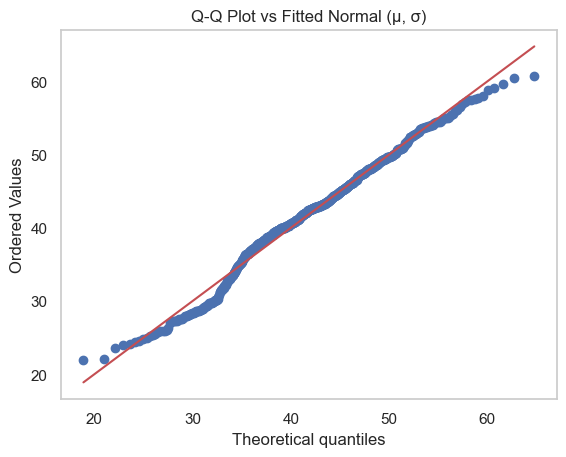

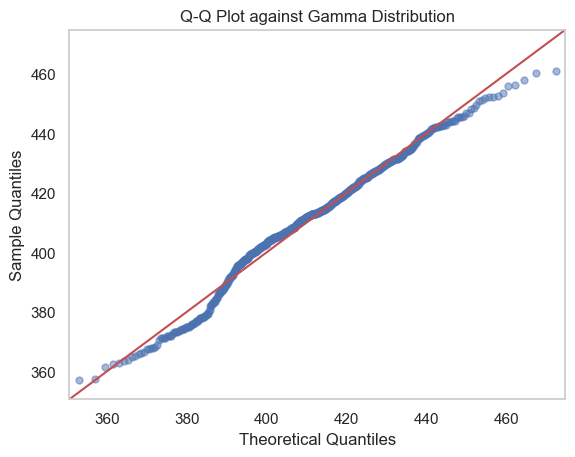

In [20]:
## Get qq plot
get_q_q_plots(year)

In [21]:
# Résultats du model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                  624
Model:                            GLM   Df Residuals:                      609
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                          20.485
Method:                          IRLS   Log-Likelihood:                -1820.0
Date:                Thu, 08 May 2025   Deviance:                       12475.
Time:                        17:31:22   Pearson chi2:                 1.25e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8306
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Analyse de coefficients significatif

In [22]:
glm_results.pvalues
# Create a DataFrame for coefficients and their significance levels
coefficients_table = pd.DataFrame({
    'Coefficient': glm_results.params,
    'P-Value': glm_results.pvalues
})

# Add significance levels based on p-values
coefficients_table['Significance'] = coefficients_table['P-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '_'
)

# Reset index to include variable names
coefficients_table.reset_index(inplace=True)
coefficients_table.rename(columns={'index': 'Variable'}, inplace=True)

coefficients_table

,Variable,Coefficient,P-Value,Significance
0,const,-3079.401640,5.710450e-21,***
1,annee,1.543997,1.612140e-21,***
2,mois,0.258963,8.060292e-07,***
3,region_Bourgogne-Franche-Comté,-4.226917,4.757261e-06,***
4,region_Bretagne,-6.906936,7.657724e-14,***
5,region_Centre-Val-de-Loire,-5.512755,2.416405e-09,***
6,region_Grand Est,4.426661,1.656044e-06,***
7,region_Hauts-de-France,-5.056441,4.422434e-08,***
8,region_Ile-de-France,2.812193,2.335178e-03,***
9,region_Normandie,-5.840891,2.578909e-10,***


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Prédiction de la dérive de sinistralité en 2025</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Test pour 2024</b></h2>

In [23]:
df_train = get_all_data_beginning_from_year(2022, 2023)
X_train = pd.get_dummies(df_train, columns = ['region'], drop_first = True,  dtype=int)
X_train = sm.add_constant(X_train)
y_train = X_train['RAC_par_personne']
X_train.drop(columns=['RAC_par_personne', 'RAC', 'monthly_population'], inplace=True)

glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                  312
Model:                            GLM   Df Residuals:                      297
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                          17.919
Method:                          IRLS   Log-Likelihood:                -885.22
Date:                Thu, 08 May 2025   Deviance:                       5322.0
Time:                        17:31:22   Pearson chi2:                 5.32e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8594
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [24]:
X_test = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'monthly_population', 'RAC_par_personne'])

# Apply one-hot encoding to X_test
X_test = pd.get_dummies(X_test, columns=['region'], drop_first=True, dtype=int)

# Align X_test columns with X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=1)

y_test = get_all_data_beginning_from_year(2024)['RAC_par_personne']

# Make predictions
glm_model_predictions = glm_results.predict(X_test)

Results_df = pd.concat([X_test.reset_index(drop=True), pd.DataFrame({'true_values' :y_test.to_list(), 'predicted_values' :glm_model_predictions.to_list()}).reset_index(drop=True)], axis = 1)

print("La MAPE pour le modèle GLM pour la prédiction du RAC est : {}%".format(round(mean_absolute_percentage_error(y_test, glm_model_predictions) * 100,  2)))
Results_df.drop(columns=[col for col in Results_df.columns if col.startswith('region')], inplace=True)


La MAPE pour le modèle GLM pour la prédiction du RAC est : 9.14%


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Prédiction du RAC 2025 - 2026
</b></h2>

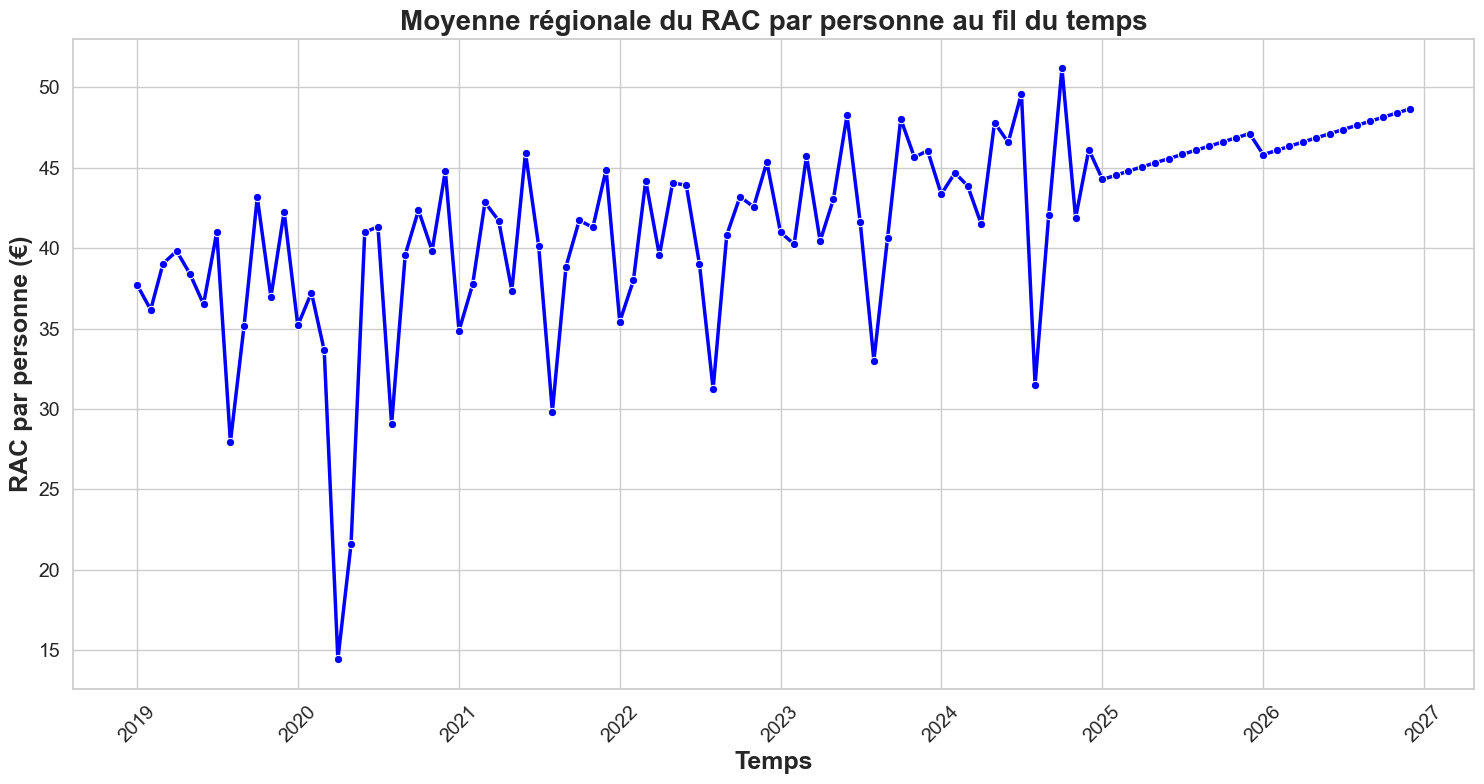

In [35]:
final_glm_model, final_glm_results = GLM_model(2021)

X_2025 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'monthly_population', 'RAC_par_personne'])



# Apply one-hot encoding to X_test
X_2025 = pd.get_dummies(X_2025, columns=['region'], drop_first=True, dtype=int)

# Align X_test columns with X_train
X_2025 = X_test.reindex(columns=X_train.columns, fill_value=1)

X_2025['annee'] = 2025

X_2026 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'monthly_population', 'RAC_par_personne'])

# Apply one-hot encoding to X_test
X_2026 = pd.get_dummies(X_2026, columns=['region'], drop_first=True, dtype=int)

# Align X_test columns with X_train
X_2026 = X_test.reindex(columns=X_train.columns, fill_value=1)

X_2026['annee'] = 2026

predictions_2025 = final_glm_results.predict(X_2025)

predictions_2026 = final_glm_results.predict(X_2026)

Results_2025_df = pd.concat([X_2025.reset_index(drop=True), pd.DataFrame({'RAC_par_personne' :predictions_2025.to_list()}).reset_index(drop=True)], axis = 1).drop(columns = ['const'])

Results_2026_df = pd.concat([X_2026.reset_index(drop=True), pd.DataFrame({'RAC_par_personne' :predictions_2026.to_list()}).reset_index(drop=True)], axis = 1).drop(columns = ['const'])


Results_2025_agregated_df = Results_2025_df[['annee', 'mois', 'RAC_par_personne']].groupby(by=['annee', 'mois']).mean().reset_index()

Results_2026_agregated_df = Results_2026_df[['annee', 'mois', 'RAC_par_personne']].groupby(by=['annee', 'mois']).mean().reset_index()

data_prior_to_2024 = get_all_data_beginning_from_year(2019).drop(columns=['region', 'RAC', 'monthly_population']).groupby(['annee', 'mois']).mean().reset_index()

all_temporal_data = pd.concat([data_prior_to_2024, Results_2025_agregated_df, Results_2026_agregated_df])

all_temporal_data


# Create a new column combining 'annee' and 'mois' as a datetime object
all_temporal_data['time'] = pd.to_datetime(all_temporal_data['annee'].astype(str) + '-' + all_temporal_data['mois'].astype(str), format='%Y-%m')

# Plot RAC_par_personne as a function of time
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_temporal_data, x='time', y='RAC_par_personne', marker='o', linewidth=2.5, color='blue')

# Title and labels
plt.title("Moyenne régionale du RAC par personne au fil du temps", fontsize=20, fontweight='bold')
plt.xlabel("Temps", fontsize=18, fontweight='bold')
plt.ylabel("RAC par personne (€)", fontsize=18, fontweight='bold')

# Optional: Ticks font size
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()



**Remarque:** Cette visualisation pourrait suggérer que notre GLM n'est pas performant. Cependant, examinons les résultats obtenus : en dehors des données régionales que nous avons agrégées dans la visualisation ci-dessus, seules l'année et le mois sont utilisées comme variables explicatives. Cela produit un effet attendu : pour une année donnée, l'évolution du RAC est linéaire (car nous utilisons un GLM). Pour améliorer la performance du modèle, une option serait de créer des harmoniques à partir de la variable mois afin de capturer les variations mensuelles du RAC. Nous n'avons pas suivi cette approche dans ce Notebook, car nous avons privilégié une étude interprétable.